# Supplements

Notebook to make regional, national, and city-level exposure trends tables and supplement figures. <br>

Note: Pct of Global Total Comes from cpt_MS_calulations_ERA5_RH.ipynb <br>

By Cascade Tuholske Sep 2020 / Updated Feb 2021 for PNASv2 CPT  <br>

Updated CPT June 2021 for PNASv3

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams
import glob
from shapely.geometry import Point 
import matplotlib.gridspec as gridspec
import matplotlib
import os

In [2]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 
def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [3]:
#### Load Data
DATA = 'wbgtmax30' # UPDATE 

# file paths
DATA_IN = "/scratch/cascade/UEH-daily/stats/"  
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = os.path.join(DATA_IN,DATA+'_EXP.json')
HI_STATS = pd.read_json(FN_IN, orient = 'split')

# Set scale
scale = 10**9

In [4]:
HI_STATS.head()

,ID_HDC_G0,year,tot_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,18,2006,2,622283.428656,494664.495616,661553.577433,1.244567e+06,989328.991233,255237.866079
1,22,2006,2,70915.650551,52064.452435,73006.671133,1.418313e+05,104128.904869,37702.396233
2,26,2006,3,247944.032154,194088.886834,268055.635628,7.438321e+05,582266.660503,161565.435959
3,27,2006,2,90805.062622,80540.779940,93335.494324,1.816101e+05,161081.559880,20528.565365
4,28,1998,1,68062.052369,59320.971209,91449.606255,6.806205e+04,59320.971209,8741.081160


In [5]:
# Drop IDs where days 1983 = 1 with none else. throws error in regressions 

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['tot_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['tot_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

303518
303178


In [6]:
#### Add In Meta Data (e.g. geographic data)
meta_fn = os.path.join('/home/cascade/projects/UrbanHeat/data/interim/','GHS-UCDB-IDS.csv')
meta_data = pd.read_csv(meta_fn)

#### Merge in meta
HI_STATS = HI_STATS.merge(meta_data, on = 'ID_HDC_G0', how = 'left')

##  GHCN/GSOD Data Subset

In [ ]:
FN_IN = 'raw/ValidationData/Validated/GHCN-and-GSOD-CHIRTSTmax_ERA5_meta-with-validation.csv'
GHCN = pd.read_csv(DATA_IN+FN_IN)
GHCN.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
GHCN.head()

In [ ]:
# Turn into gdf
# creating a geometry column 
GHCN['geometry'] = [Point(xy) for xy in zip(GHCN['longitudes'], GHCN['latitudes'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
GHCN_gdf = gpd.GeoDataFrame(GHCN, crs=crs)

In [ ]:
# Load GHS & Meta
GHS = gpd.read_file('/home/cascade/projects/UrbanHeat/data/raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp')
META = pd.read_csv('/home/cascade/projects/UrbanHeat/data/interim/GHS-UCDB-IDS.csv')

In [ ]:
# Merge all the data
merge = GHS[['ID_HDC_G0','geometry']]
merge = merge.merge(META, on = 'ID_HDC_G0', how = 'inner')

In [ ]:
# Get urban GHCN
urban = gpd.sjoin(GHCN_gdf, merge, how="inner", op='within')
urban.drop(labels = 'index_right', axis = 1, inplace = True)
print('num of urban stations', len(urban))

In [ ]:
# save the data
fn_out = DATA_IN+'interim/GHCN-and-GSOD-CHIRTSTmax_ERA5_meta-with-validation-ghs-ucdb.shp'
urban.to_file(fn_out)

In [ ]:
#### Make Figure and save it -- CHIRTS CORRELATION
FN_OUT = 'FIG-WBGT32-S1.tiff'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

# lims
xlim =[-.1,1]

# all urban stations
f_ax1 = fig.add_subplot(gs[:, 0:2])
f_ax1.hist(urban['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax1.hist(urban['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax1.set_xlim(xlim)
f_ax1.set_title('Global', fontsize = 18)
f_ax1.set_ylabel('Number of Stations', fontsize = 16)
f_ax1.set_xlabel('Correlation', fontsize = 16)

In [ ]:
#### Make Figure and save it -- CHIRTS CORRELATION
FN_OUT = 'FIG-WBGT32-S1'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

# lims
xlim = xlim =[-.1,1]

# all urban stations
f_ax1 = fig.add_subplot(gs[:, 0:2])
f_ax1.hist(urban['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax1.hist(urban['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax1.set_xlim(xlim)
f_ax1.set_title('Global', fontsize = 18)
f_ax1.set_ylabel('Number of Stations', fontsize = 16)
f_ax1.set_xlabel('Correlation', fontsize = 16)

# Legend
labels = ['PGF', 'CHIRTS-daily']
plt.legend(labels, fontsize = 16)

# Africa
f_ax2 = fig.add_subplot(gs[0, 2])
region = 'Northern America'
data = urban[urban['sub-region'] == region]
f_ax2.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax2.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax2.set_xlim(xlim)
f_ax2.set_title('Northern America', fontsize = 16)

# S Asia 
f_ax3 = fig.add_subplot(gs[1, 2])
region = 'Southern Asia'
data = urban[urban['sub-region'] == region]
f_ax3.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax3.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax3.set_xlim(xlim)
f_ax3.set_title('Southern Asia', fontsize = 16)

# Africa
f_ax4 = fig.add_subplot(gs[0, 3])
region = 'Africa'
data = urban[urban['region'] == region]
f_ax4.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax4.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax4.set_xlim(xlim)
f_ax4.set_title('Africa', fontsize = 16)

# Western Asia
f_ax5 = fig.add_subplot(gs[1, 3])
region = 'Western Asia'
data = urban[urban['sub-region'] == region]
f_ax5.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax5.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax5.set_xlim(xlim)
f_ax5.set_title('Western Asia', fontsize = 16)

# save it out
#plt.savefig(FIG_OUT+FN_OUT+'.tiff', dpi = 300, bbox_inches='tight') # tif
#plt.savefig(FIG_OUT+FN_OUT+'.png', dpi = 300, bbox_inches='tight') # png


In [ ]:
# India
country = 'India'
num_cities = len(GHS[GHS['CTR_MN_NM'] == country])
num_stations = len(urban[urban['CTR_MN_NM'] == country])
print('num cities in india', num_cities)
print('num stations in india', num_stations)

## Tables

In [7]:
geog = 'sub-region'
loc_list = HI_STATS[geog].unique()
list(loc_list)

['Northern America',
 'Latin America and the Caribbean',
 'Sub-Saharan Africa',
 'Northern Africa',
 'Southern Europe',
 'Western Europe',
 'Northern Europe',
 'Eastern Europe',
 'Western Asia',
 'Southern Asia',
 'Central Asia',
 'Eastern Asia',
 'South-eastern Asia',
 'Australia and New Zealand',
 'Melanesia']

In [8]:
#### Global Total People Days trend in 10^9\n - See Figure 1 or MS_calculations.ipynb
global_pdays = 2.108968631 * 10**9 

In [11]:
#### regional-level exposure trajectories 
fn_out = os.path.join('/scratch/cascade/UEH-daily/', 'ms-tables/'+DATA+'_EXP-REGION.csv')
geog = 'sub-region'
loc_list = HI_STATS[geog].unique()

pday_coef = []
pday_p =[]
heat_coef = []
heat_p =[]
pop_coef = []
pop_p =[]
for loc in loc_list:
    print(loc)
    
    # Pdays OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days')
    pday_coef.append(coef)
    pday_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_heat')
    heat_coef.append(coef)
    heat_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_pop')
    pop_coef.append(coef)
    pop_p.append(p)
    
df = pd.DataFrame()
df['region'] = loc_list
df['pdays_Coef'] = pday_coef
df['pdays_pvalue'] = pday_p
df['heat_Coef'] = heat_coef
df['heat_pvalue'] = heat_p
df['pop_Coef'] = pop_coef
df['pop_pvalue'] = pop_p
df['pct_globe'] = df['pdays_Coef'] / global_pdays * 100 
df.to_csv(fn_out)

Northern America
Latin America and the Caribbean
Sub-Saharan Africa
Northern Africa
Southern Europe
Western Europe
Northern Europe
Eastern Europe
Western Asia
Southern Asia
Central Asia
Eastern Asia
South-eastern Asia
Australia and New Zealand
Melanesia


In [12]:
#### check
df.sort_values('pct_globe', ascending = False)

,region,pdays_Coef,pdays_pvalue,heat_Coef,heat_pvalue,pop_Coef,pop_pvalue,pct_globe
9,Southern Asia,1265842936,0.000,449350221,0.000,816492715,0.000,60.021895
8,Western Asia,299850645,0.000,89666192,0.000,210184452,0.000,14.217881
12,South-eastern Asia,173488868,0.000,61242581,0.000,112246287,0.000,8.226242
2,Sub-Saharan Africa,158753654,0.000,47793536,0.000,110960118,0.000,7.527549
11,Eastern Asia,124605575,0.000,38724326,0.076,85881248,0.000,5.908366
1,Latin America and the Caribbean,41631755,0.000,16456850,0.000,25174904,0.000,1.974034
3,Northern Africa,35835632,0.000,9746304,0.002,26089328,0.000,1.699202
0,Northern America,8620578,0.001,3209500,0.080,5411078,0.000,0.408758
10,Central Asia,147521,0.293,-12002,0.870,159523,0.000,0.006995
14,Melanesia,92013,0.000,24636,0.000,67377,0.000,0.004363


pdays east asia
(124605575, 0.37, 0.0)
heat east asia
(38724326, 0.08, 0.076)


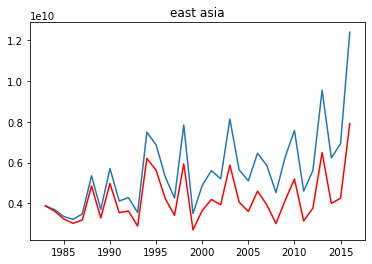

In [13]:
# Check Eastern Asia
# Get Data
df = HI_STATS[HI_STATS['sub-region'] == 'Eastern Asia']
X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(df.groupby('year')['people_days'].sum()).reshape((-1, 1))

plt.plot(X_year, Y_stats)
X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(df.groupby('year')['people_days_heat'].sum()).reshape((-1, 1))
plt.plot(X_year, Y_stats, color = 'red')
plt.title('east asia')

print('pdays east asia')
print(lm_func(df, 'people_days'))

print('heat east asia')
print(lm_func(df, 'people_days_heat'))

Text(0.5, 1.0, 'east asia')

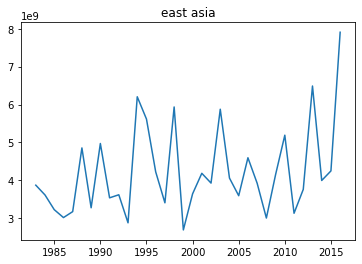

In [14]:
plt.plot(X_year, Y_stats)
plt.title('east asia')

In [45]:
#### National-level exposure trajectories 
fn_out = os.path.join('/scratch/cascade/UEH-daily/', 'ms-tables/'+DATA+'_EXP-COUNTRIES.csv')
geog = 'CTR_MN_NM'
loc_list = HI_STATS[geog].unique()

pday_coef = []
pday_p =[]
heat_coef = []
heat_p =[]
pop_coef = []
pop_p =[]
for loc in loc_list:
    
    print(loc)
    
    # Pdays OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days')
    pday_coef.append(coef)
    pday_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_heat')
    heat_coef.append(coef)
    heat_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_pop')
    pop_coef.append(coef)
    pop_p.append(p)
    
df = pd.DataFrame()
df[geog] = loc_list
df['pdays_Coef'] = pday_coef
df['pdays_pvalue'] = pday_p
df['heat_Coef'] = heat_coef
df['heat_pvalue'] = heat_p
df['pop_Coef'] = pop_coef
df['pop_pvalue'] = pop_p
df['pct_globe'] = df['pdays_Coef'] / global_pdays * 100 
df.to_csv(fn_out)

United States
Mexico
Guatemala
El Salvador
Honduras
Nicaragua
Belize
Costa Rica
Peru
Ecuador
Cuba
Panama
Colombia
Bahamas
Brazil
Haiti
Venezuela
Dominican Republic
Curaçao
Bolivia
Canada
Puerto Rico
Argentina
Trinidad and Tobago
Suriname
Paraguay
Uruguay
Senegal
Gambia
Mauritania
Guinea-Bissau
Guinea
Sierra Leone
Mali
Liberia
Morocco
Ivory Coast
Algeria
Spain
Burkina Faso
Ghana
France
United Kingdom
Togo
Niger
Benin
Nigeria
Tunisia
Equatorial Guinea
Cameroon
Gabon
Italy
Poland
Libya
Republic of Congo
Angola
Democratic Republic of the Congo
Croatia
Bosnia and Herzegovina
Chad
Central African Republic
Serbia
Albania
South Africa
Romania
Greece
Bulgaria
Sudan
Turkey
Botswana
Egypt
Zambia
South Sudan
Swaziland
Cyprus
Zimbabwe
Russia
Mozambique
Palestina
Israel
Syria
Lebanon
Jordan
Saudi Arabia
Ethiopia
Georgia
Eritrea
Tanzania
Iraq
Kenya
Azerbaijan
Iran
Kazakhstan
Somalia
Madagascar
Djibouti
Yemen
Kuwait
Turkmenistan
Bahrain
Qatar
Uzbekistan
United Arab Emirates
Oman
Afghanistan
Pakistan
T

In [16]:
#### check
df.sort_values('pct_globe', ascending = False)

,CTR_MN_NM,pdays_Coef,pdays_pvalue,heat_Coef,heat_pvalue,pop_Coef,pop_pvalue,pct_globe
107,India,1104046550,0.000,419454516,0.000,684592033,0.000,52.350070
111,Bangladesh,166561597,0.000,62166588,0.000,104395009,0.000,7.897775
105,Pakistan,143097655,0.000,26254530,0.000,116843125,0.000,6.785196
108,China,117537897,0.000,33188919,0.100,84348977,0.000,5.573241
46,Nigeria,65996622,0.000,25866967,0.000,40129654,0.000,3.129332
...,...,...,...,...,...,...,...,...
66,Bulgaria,-2274,0.471,-1798,0.588,-476,0.177,-0.000108
106,Tajikistan,-3868,0.495,-4501,0.365,633,0.473,-0.000183
64,Romania,-16038,0.370,-15499,0.358,-539,0.614,-0.000760
65,Greece,-29095,0.442,-29852,0.396,756,0.827,-0.001380


## Top fifty cities

In [27]:
#### Top fifty cities
fn_in = os.path.join(DATA_IN,DATA+'_TREND_PDAYS05.json')
cities = pd.read_json(fn_in, orient = 'split')

In [28]:
cities.columns

Index(['ID_HDC_G0', 'coef_pdays', 'p_value_pdays', 'coef_heat', 'p_value_heat',
       'coef_pop', 'p_value_pop', 'coef_totDays', 'p_value_totDays',
       'coef_attrib', 'CTR_MN_NM', 'UC_NM_MN', 'GCPNT_LAT', 'GCPNT_LON',
       'region', 'sub-region', 'intermediate-region', 'P1983', 'P2016'],
      dtype='object')

In [34]:
cols = ['ID_HDC_G0', 'UC_NM_MN','CTR_MN_NM','coef_pdays','p_value_pdays','coef_heat',
       'p_value_heat','coef_pop','p_value_pop']
sub = cities[cols]
top50 = sub.sort_values('coef_pdays', ascending = False).head(50)
top50['pct_globe'] = top50['coef_pdays'] / global_pdays * 100 
top50['pct_pop_tot'] = top50['coef_pop'] / top50['coef_pdays'] * 100

fn_out = os.path.join('/scratch/cascade/UEH-daily/', 'ms-tables/'+DATA+'_EXP-TOP50.csv')

top50.to_csv(fn_out)

## Figures

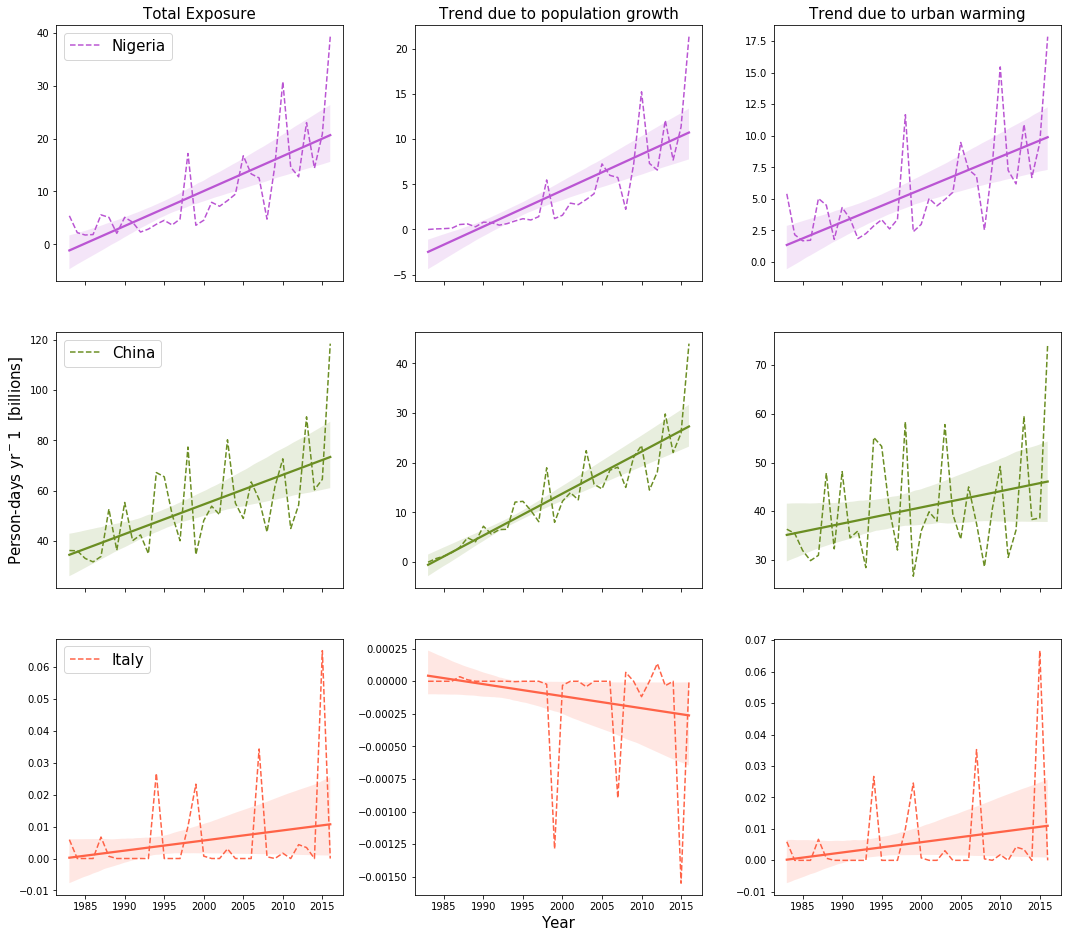

In [36]:
#### Make Supplement 2 
FN_OUT = 'FIGS7-Final.tiff'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(3, 3, figsize = (18, 16), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**8

#### Nigeria
country = 'Nigeria'
color = 'mediumorchid'
col = 'people_days'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[0][0].legend(labels = [country], fontsize = 15)
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][0], scatter = False, truncate = True)
#axs[0][0].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][2], scatter = False, truncate = True)
#axs[0][2].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)

#### China
country = 'China'
color = 'olivedrab'
col = 'people_days'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[1][0].legend(labels = [country], fontsize = 15)
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][0], scatter = False, truncate = True)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][2], scatter = False, truncate = True)

#### Italy
country = 'Italy'
color = 'tomato'
col = 'people_days'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[2][0].legend(labels = [country], loc = 'upper left', fontsize = 15)
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][0], scatter = False, truncate = True)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][2], scatter = False, truncate = True)

# Axis labels & Titles
axs[0][0].set_title('Total Exposure', size = 15 )
axs[0][1].set_title('Trend due to population growth', size = 15)
axs[0][2].set_title('Trend due to urban warming', size = 15)
axs[2][1].set_xlabel('Year', fontsize = 15)
axs[1][0].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 15)

# save it out
plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')

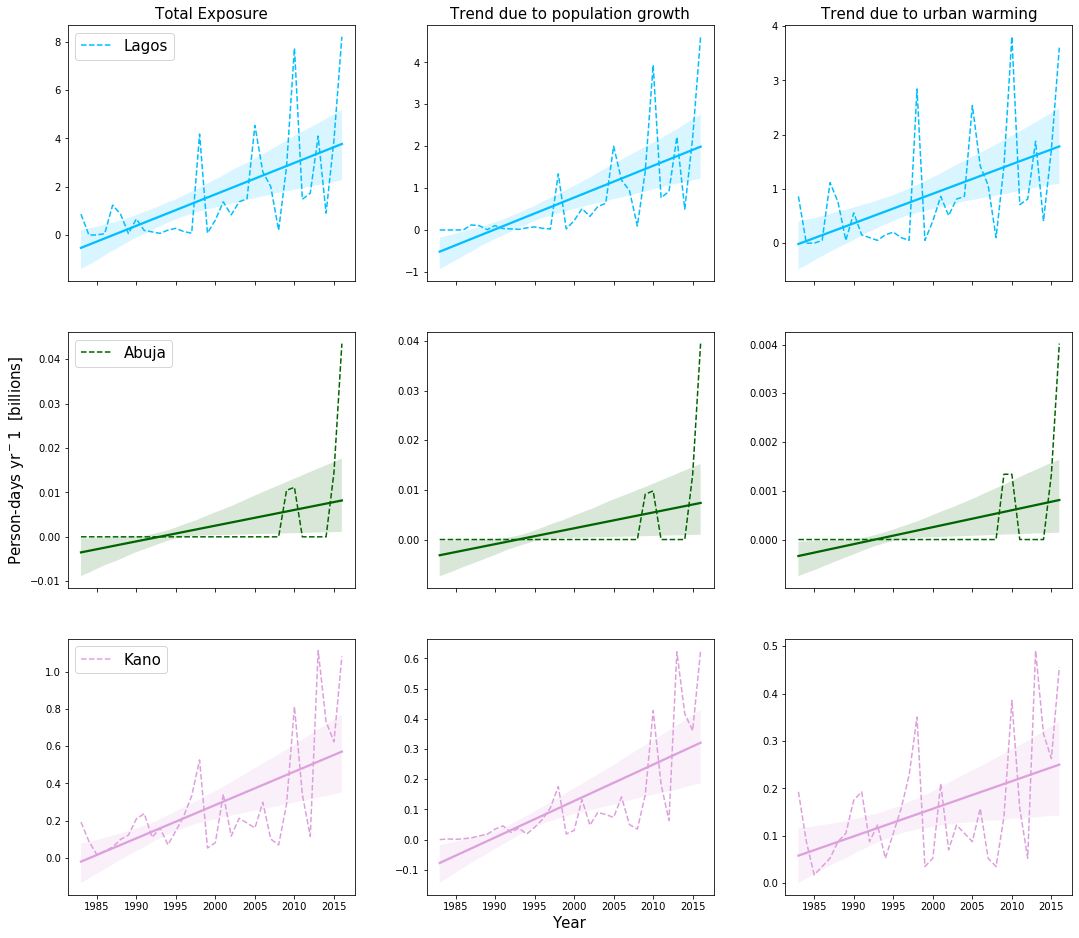

In [37]:
#### Make Figure S3 and save it
FN_OUT = 'FIGS8-Final.tiff'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(3, 3, figsize = (18, 16), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**8

#### Lagos
city = 2125 
color = 'deepskyblue'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[0][0].legend(labels = ['Lagos'], fontsize = 15)
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][0], scatter = False, truncate = True)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][2], scatter = False, truncate = True)

#### Abuja
city = b #10687
color = 'darkgreen'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[1][0].legend(labels = ['Abuja'], fontsize = 15)
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][0], scatter = False, truncate = True)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][2], scatter = False, truncate = True)

#### Kano
city = 2717
color = 'plum'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[2][0].legend(labels = ['Kano'], fontsize = 15)
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][0], scatter = False, truncate = True)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][2], scatter = False, truncate = True)

# Axis labels & Titles
axs[0][0].set_title('Total Exposure', size = 15 )
axs[0][1].set_title('Trend due to population growth', size = 15)
axs[0][2].set_title('Trend due to urban warming', size = 15)
axs[2][1].set_xlabel('Year', fontsize = 15)
axs[1][0].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 15)

# save it out
plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')

In [39]:
HI_STATS[HI_STATS['ID_HDC_G0'] == 2125] # 2125 #2565

,ID_HDC_G0,year,tot_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,CTR_MN_NM,UC_NM_MN,GCPNT_LAT,GCPNT_LON,region,sub-region,intermediate-region
21754,2125,1983,17,5.076310e+06,5.076310e+06,1.157504e+07,8.629727e+07,8.629727e+07,0.000000e+00,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21755,2125,1986,1,5.488809e+06,5.076310e+06,1.157504e+07,5.488809e+06,5.076310e+06,4.124993e+05,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21756,2125,1987,22,5.626309e+06,5.076310e+06,1.157504e+07,1.237788e+08,1.116788e+08,1.209998e+07,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21757,2125,1988,15,5.763809e+06,5.076310e+06,1.157504e+07,8.645713e+07,7.614465e+07,1.031248e+07,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21758,2125,1989,1,5.901309e+06,5.076310e+06,1.157504e+07,5.901309e+06,5.076310e+06,8.249986e+05,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21759,2125,1990,11,6.038808e+06,5.076310e+06,1.157504e+07,6.642689e+07,5.583941e+07,1.058748e+07,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21760,2125,1991,3,6.217524e+06,5.076310e+06,1.157504e+07,1.865257e+07,1.522893e+07,3.423641e+06,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21761,2125,1992,2,6.396239e+06,5.076310e+06,1.157504e+07,1.279248e+07,1.015262e+07,2.639858e+06,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21762,2125,1993,1,6.574954e+06,5.076310e+06,1.157504e+07,6.574954e+06,5.076310e+06,1.498644e+06,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa
21763,2125,1994,3,6.753670e+06,5.076310e+06,1.157504e+07,2.026101e+07,1.522893e+07,5.032079e+06,Nigeria,Lagos [NGA],6.567182,3.297388,Africa,Sub-Saharan Africa,Western Africa


## Indian Cities

In [40]:
top50[(top50['UC_NM_MN'] == 'Delhi [IND]') | (top50['UC_NM_MN'] == 'Kolkata (Calcutta) [IND]')]

,ID_HDC_G0,UC_NM_MN,CTR_MN_NM,coef_pdays,p_value_pdays,coef_heat,p_value_heat,coef_pop,p_value_pop,pct_globe,pct_pop_tot
3650,6955,Delhi [IND],India,5.539828e+07,0.0,1.433134e+07,0.0,4.106694e+07,0.0,2.626795,74.130357
6212,9691,Kolkata (Calcutta) [IND],India,5.223038e+07,0.0,2.732002e+07,0.0,2.491036e+07,0.0,2.476584,47.693242


In [41]:
# Quick numbers Delhi
coef_heat = top50[top50['ID_HDC_G0'] == 6955]['coef_heat']
coef_pop = top50[top50['ID_HDC_G0'] == 6955]['coef_pop']
coef_pdays = top50[top50['ID_HDC_G0'] == 6955]['coef_pdays']
print('Dehli heat as pct of total', coef_heat/coef_pdays)

Dehli heat as pct of total 3650    0.258696
dtype: float64


In [42]:
# Quick numbers Kolkata
coef_heat = top50[top50['ID_HDC_G0'] == 9691]['coef_heat']
coef_pop = top50[top50['ID_HDC_G0'] == 9691]['coef_pop']
coef_pdays = top50[top50['ID_HDC_G0'] == 9691]['coef_pdays']
print('Dehli heat as pct of total', coef_heat/coef_pdays)

Dehli heat as pct of total 6212    0.523068
dtype: float64


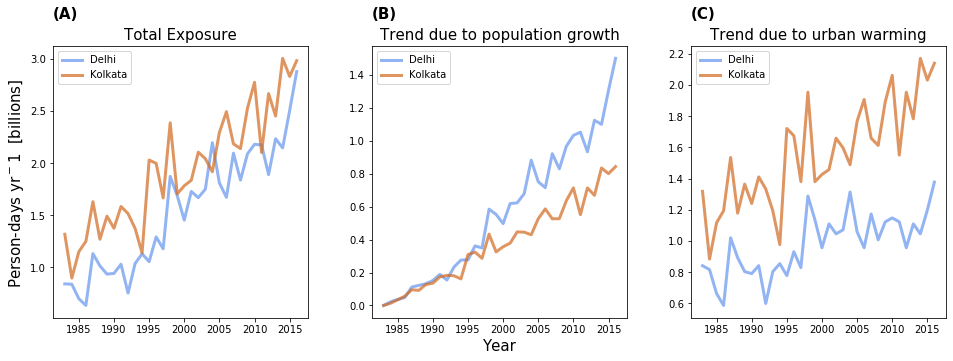

In [44]:
#### Make Figure S3 and save it
FN_OUT = os.path.join(FIG_OUT,'FIGS10-Final.tiff')

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**9

#### Total
city = 6955 # Delhi
color = 'cornflowerblue'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0].plot(X_year, Y_stats, color = color, linestyle = '-', linewidth = 3, alpha = 0.7)
axs[0].legend(labels = ['Delhi', 'Kolkata'])

city = 9691 # Kolkata 
color = 'chocolate'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0].plot(X_year, Y_stats, color = color, linestyle = '-', linewidth = 3, alpha = 0.7)
axs[0].legend(labels = ['Delhi', 'Kolkata'])

#### Pop
city = 6955 # Delhi
color = 'cornflowerblue'
col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[1].plot(X_year, Y_stats, color = color, linestyle = '-', linewidth = 3, alpha = 0.7)
axs[1].legend(labels = ['Delhi', 'v'])

city = 9691 # Kolkata 
color = 'chocolate'
col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[1].plot(X_year, Y_stats, color = color, linestyle = '-', linewidth = 3, alpha = 0.7)
axs[1].legend(labels = ['Delhi', 'Kolkata'])

#### Heat
city = 6955 # Delhi
color = 'cornflowerblue'
col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[2].plot(X_year, Y_stats, color = color, linestyle = '-', linewidth = 3, alpha = 0.7)
axs[2].legend(labels = ['Delhi', 'Kolkata'])

city = 9691 # Kolkata 
color = 'chocolate'
col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[2].plot(X_year, Y_stats, color = color, linestyle = '-', linewidth = 3, alpha = 0.7)
axs[2].legend(labels = ['Delhi', 'Kolkata'])

# Add text
axs[0].text(0.00, 1.1, '(A)', transform=axs[0].transAxes, size=15, fontweight='bold')
axs[1].text(1.25, 1.1, '(B)', transform=axs[0].transAxes, size=15, fontweight='bold')
axs[1].text(1.25*2, 1.1, '(C)', transform=axs[0].transAxes, size=15, fontweight='bold')
axs[0].set_title('Total Exposure', size = 15 )
axs[1].set_title('Trend due to population growth', size = 15)
axs[2].set_title('Trend due to urban warming', size = 15)
axs[1].set_xlabel('Year', fontsize = 15)
axs[0].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 15)

# save it out
plt.savefig(FN_OUT, dpi = 300, bbox_inches='tight')

# CHIRTS vs ERA5
CPT June 2021 - Old code

In [ ]:
PATH = '/home/CHIRTS/csvs/Kolkata/'
OUT = '/home/cascade/projects/UrbanHeat/figures/'
fns = sorted(glob.glob(PATH+'*'))

In [ ]:
fns

In [ ]:
# #### Make Figure S3 and save it
# FN_OUT = 'FIG-S2.tiff'

# rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

# fig, axs = plt.subplots(5, 1, figsize = (20, 14), sharex=True)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

# # .001
# chirts = pd.read_csv('/home/CHIRTS/csvs/Kolkata/CHIRTSmax.daily.timeseries.001x001.csv')
# era5 = pd.read_csv('/home/CHIRTS/csvs/Kolkata/ERA5_Tmax.daily.timeseries.001x001.csv')
# axs[0].plot(chirts['year'],chirts['151'])
# axs[0].plot(era5['year'],era5['151'])
# axs[0].set_title('Mean Tmax 1 x 1 pixel', fontsize = 15)
# axs[0].legend(labels = ['CHIRTS-daily', 'ERA5'], fontsize = 15, loc = 'upper right')
# axs[0].set_xlim([1982,2016]);
# #axs[0].set_xlabel('Year', fontsize = 15)
# axs[0].set_ylabel('Tmax °C', fontsize = 15)

# # .005
# chirts = pd.read_csv('/home/CHIRTS/csvs/Kolkata/CHIRTSmax.daily.timeseries.005x005.csv')
# era5 = pd.read_csv('/home/CHIRTS/csvs/Kolkata/ERA5_Tmax.daily.timeseries.005x005.csv')
# axs[1].plot(chirts['year'],chirts['151'])
# axs[1].plot(era5['year'],era5['151'])
# axs[1].set_title('Mean Tmax 5 x 5 pixels', fontsize = 15)
# axs[1].legend(labels = ['CHIRTS-daily', 'ERA5'], fontsize = 15, loc = 'upper right')
# axs[1].set_xlim([1982,2016]);
# #axs[1].set_xlabel('Year', fontsize = 15)
# axs[1].set_ylabel('Tmax °C', fontsize = 15)

# # 0.011
# chirts = pd.read_csv('/home/CHIRTS/csvs/Kolkata/CHIRTSmax.daily.timeseries.011x011.csv')
# era5 = pd.read_csv('/home/CHIRTS/csvs/Kolkata/ERA5_Tmax.daily.timeseries.011x011.csv')
# axs[2].plot(chirts['year'],chirts['151'])
# axs[2].plot(era5['year'],era5['151'])
# axs[2].set_title('Mean Tmax 11 x 11 pixels', fontsize = 15)
# axs[2].legend(labels = ['CHIRTS-daily', 'ERA5'], fontsize = 15, loc = 'upper right')
# axs[2].set_xlim([1982,2016]);
# #axs[2].set_xlabel('Year', fontsize = 15)
# axs[2].set_ylabel('Tmax °C', fontsize = 15)

# # 025
# chirts = pd.read_csv('/home/CHIRTS/csvs/Kolkata/CHIRTSmax.daily.timeseries.025x025.csv')
# era5 = pd.read_csv('/home/CHIRTS/csvs/Kolkata/ERA5_Tmax.daily.timeseries.025x025.csv')
# axs[3].plot(chirts['year'],chirts['151'])
# axs[3].plot(era5['year'],era5['151'])
# axs[3].set_title('Mean Tmax 25 x 25 pixels', fontsize = 15)
# axs[3].legend(labels = ['CHIRTS-daily', 'ERA5'], fontsize = 15, loc = 'upper right')
# axs[3].set_xlim([1982,2016]);
# #axs[3].set_xlabel('Year', fontsize = 15)
# axs[3].set_ylabel('Tmax °C', fontsize = 15)

# # 051
# chirts = pd.read_csv('/home/CHIRTS/csvs/Kolkata/CHIRTSmax.daily.timeseries.051x051.csv')
# era5 = pd.read_csv('/home/CHIRTS/csvs/Kolkata/ERA5_Tmax.daily.timeseries.051x051.csv')
# axs[4].plot(chirts['year'],chirts['151'])
# axs[4].plot(era5['year'],era5['151'])
# axs[4].set_title('Mean Tmax 51 x 51 pixels', fontsize = 15)
# axs[4].legend(labels = ['CHIRTS-daily', 'ERA5'], fontsize = 15, loc = 'upper right')
# axs[4].set_xlim([1982,2016]);
# axs[4].set_xlabel('Year', fontsize = 15)
# axs[4].set_ylabel('Tmax °C', fontsize = 15)

# # Add text
# # axs[0].text(0.00, 1.05, '(A)', transform=axs[0].transAxes, size=15, fontweight='bold')
# # axs[0].text(0.00, -.25, '(B)', transform=axs[0].transAxes, size=15, fontweight='bold')
# # axs[0].text(0.00, -1.55, '(C)', transform=axs[0].transAxes, size=15, fontweight='bold')
# # axs[0].text(0.00, -1.75, '(D)', transform=axs[0].transAxes, size=15, fontweight='bold')
# # axs[0].text(0.00, -2.55, '(F)', transform=axs[0].transAxes, size=15, fontweight='bold')

# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)

# # save it out
# plt.savefig(OUT+FN_OUT, dpi = 300, bbox_inches='tight')